In [143]:
import h5py
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss 
from sklearn.model_selection import cross_val_score
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb
import pandas as pd
import numpy as np


from scipy import signal
from intervals import FloatInterval


from scipy.signal import detrend
from mne.time_frequency import morlet
from scipy.signal import butter, lfilter #Import the extra module required
from statsmodels import robust


In [196]:
dataPath="C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"
h5filename="train.h5"
h5file= dataPath + h5filename
h5 = h5py.File(h5file, "r")
eeg_1 = pd.DataFrame(h5['eeg_1'][:])
eeg_2 = pd.DataFrame(h5['eeg_2'][:])
eeg_3 = pd.DataFrame(h5['eeg_3'][:])
eeg_4 = pd.DataFrame(h5['eeg_4'][:])

In [3]:
h5['eeg_1'][:]

array([[-27.960703 , -31.372751 , -33.740234 , ...,  73.3584   ,
         68.58676  ,  66.44375  ],
       [ 67.39049  ,  74.80617  ,  79.84329  , ...,  27.506912 ,
         25.942848 ,  28.08304  ],
       [ 28.917696 ,  22.577665 ,  13.023452 , ...,   3.510584 ,
          3.8765454,   2.1897657],
       ...,
       [ 26.838522 ,  33.31461  ,  38.826202 , ...,  50.52807  ,
         51.148952 ,  49.368317 ],
       [ 48.409428 ,  47.085167 ,  43.76022  , ...,   5.7415524,
          9.368454 ,  15.295236 ],
       [ 20.835394 ,  23.65815  ,  26.164165 , ..., -60.93345  ,
        -56.970284 , -54.975235 ]], dtype=float32)

In [4]:
fs=125
freq1, pxx_den1 = signal.periodogram(eeg_1, fs, axis=1)
PSD1= pd.DataFrame(data=pxx_den1, columns= freq1)

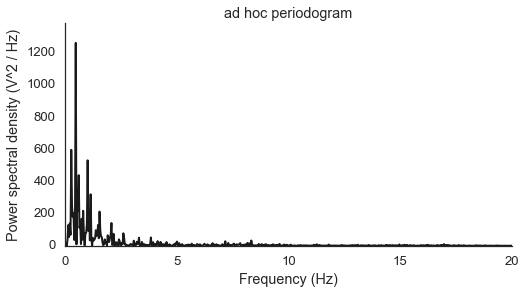

In [7]:
sig = PSD1.iloc[1,:]
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freq1, sig, color='k', lw=2)
#plt.plot(psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, sig.max() * 1.1])
plt.title("ad hoc periodogram")
plt.xlim([0, 20])
sns.despine()

(251,)
(251,)


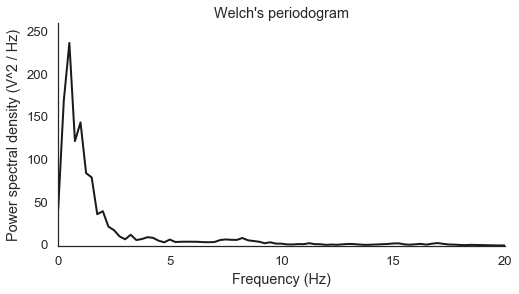

In [10]:
from scipy import signal

data = eeg_1.iloc[1,:]
sf = 125 #hz
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win, scaling='density')
print(freqs.shape)
print(psd.shape)
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
#plt.plot(psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 20])
sns.despine()

In [12]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True, normalization='full')
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()


    using multitaper spectrum estimation with 7 DPSS windows


C:\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


    using multitaper spectrum estimation with 7 DPSS windows
    using multitaper spectrum estimation with 7 DPSS windows
    using multitaper spectrum estimation with 7 DPSS windows
    using multitaper spectrum estimation with 7 DPSS windows
    using multitaper spectrum estimation with 7 DPSS windows


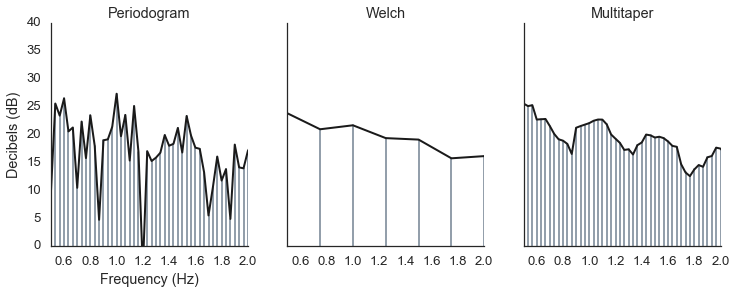

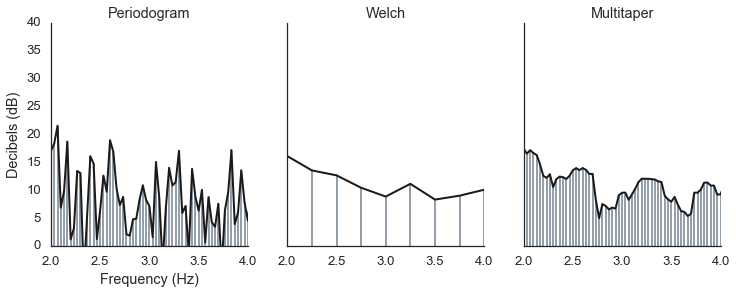

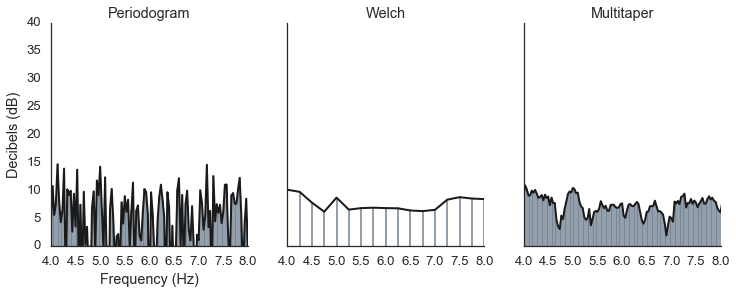

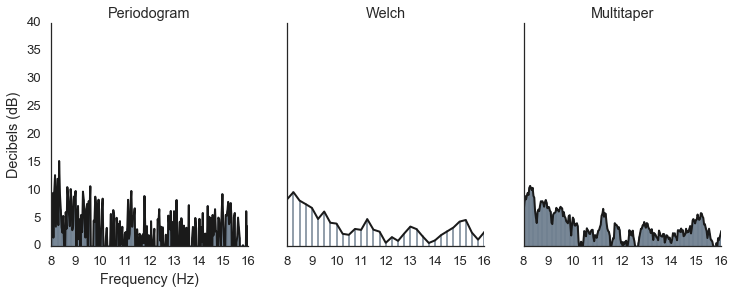

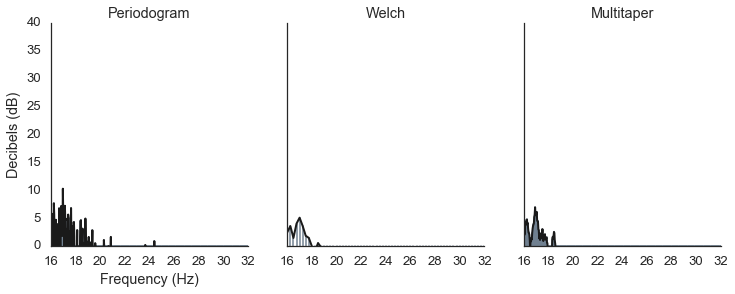

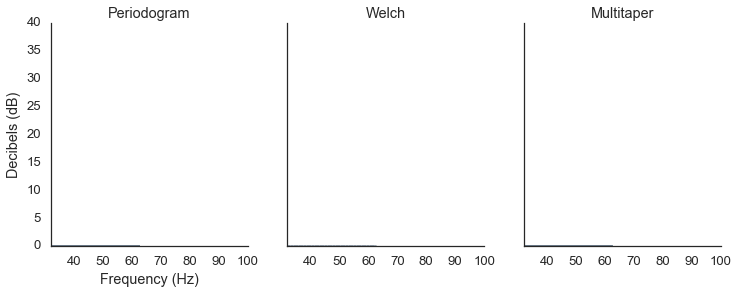

In [14]:
# Example: plot the 0.5 - 2 Hz band
data =  eeg_1.iloc[1,:]
sf=125
plot_spectrum_methods(data, sf, 4, [0.5, 2], dB=True)
plot_spectrum_methods(data, sf, 4, [2, 4], dB=True)
plot_spectrum_methods(data, sf, 4, [4, 8], dB=True)
plot_spectrum_methods(data, sf, 4, [8, 16], dB=True)
plot_spectrum_methods(data, sf, 4, [16, 32], dB=True)
plot_spectrum_methods(data, sf, 4, [32, 100], dB=True)

In [15]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
  """Compute the average power of the signal x in a specific frequency band.

  Requires MNE-Python >= 0.14.

  Parameters
  ----------
  data : 1d-array
      Input signal in the time-domain.
  sf : float
      Sampling frequency of the data.
  band : list
      Lower and upper frequencies of the band of interest.
  method : string
      Periodogram method: 'welch' or 'multitaper'
  window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
  relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

  Return
  ------
  bp : float
      Absolute or relative band power.
  """
  from scipy.signal import welch
  from scipy.integrate import simps
  from mne.time_frequency import psd_array_multitaper

  band = np.asarray(band)
  low, high = band

  if band.size != 2:
      raise ValueError("You must specify the lower and upper frequencies of the band.")

  if low > high:
      low, high = high, low

  # Compute the modified periodogram (Welch)
  if method == 'welch':
      if window_sec is not None:
          nperseg = window_sec * sf
      else:
          nperseg = (2 / low) * sf

      freqs, psd = welch(data, sf, nperseg=nperseg, scaling='density')

  elif method == 'multitaper':
      psd, freqs = psd_array_multitaper(data, sf, adaptive=True, normalization='full')

  # Find index of band in frequency vector
  idx_min = np.argmax(freqs > low) - 1
  idx_max = np.argmax(freqs > high) - 1
  idx_band = np.zeros(dtype=bool, shape=freqs.shape)
  idx_band[idx_min:idx_max] = True

  # Integral approximation of the spectrum using parabola (Simpson's rule)
  bp = simps(psd[idx_band], freqs[idx_band])

  if relative:
      bp /= simps(psd, freqs)
  return bp

# Go with Multitaper on eeg1, welch other wise 
Power computed off line and materialized on file

Moins bon qu'avant !!!


In [7]:
#Multitaper
eeg1M = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\MultitaperPower_eeg1Train.xlsx')
eeg1W = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\WelchPower_eeg1Train.xlsx')

In [8]:
#Welch
eeg2 = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\WelchPower_eeg2Train.xlsx')
eeg3 = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\WelchPower_eeg3Train.xlsx')
eeg4 = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\WelchPower_eeg4Train.xlsx')

In [13]:
naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')

In [9]:
eegM = pd.concat([eeg1M, eeg2, eeg3, eeg4], axis=1)
eegW = pd.concat([eeg1W, eeg2, eeg3, eeg4], axis=1)

In [10]:
eegM. head()

,eeg1_Slow,eeg1_Delta,eeg1_Theta,eeg1_Alpha,eeg1_Beta,eeg1_Gamma,eeg2_Slow,eeg2_Delta,eeg2_Theta,eeg2_Alpha,...,eeg3_Theta,eeg3_Alpha,eeg3_Beta,eeg3_Gamma,eeg4_Slow,eeg4_Delta,eeg4_Theta,eeg4_Alpha,eeg4_Beta,eeg4_Gamma
0,0.521211,0.096757,0.039741,0.031216,0.012514,0.000744,0.565950,0.177488,0.378638,0.392094,...,0.274568,0.327504,0.412532,0.423882,0.483528,0.132110,0.286567,0.321182,0.401434,0.451103
1,0.469488,0.091419,0.069480,0.065688,0.023386,0.001625,0.564935,0.186264,0.375853,0.394599,...,0.268709,0.323692,0.420841,0.414485,0.440146,0.095683,0.262891,0.318399,0.410998,0.428547
2,0.428673,0.082911,0.080458,0.084667,0.031695,0.002729,0.567041,0.165726,0.364199,0.392445,...,0.276280,0.348425,0.419321,0.407575,0.404504,0.140215,0.289959,0.345881,0.410900,0.426426
3,0.636225,0.035809,0.020656,0.003359,0.000177,0.000005,0.493194,0.171874,0.421624,0.438583,...,0.378303,0.404108,0.433959,0.346395,0.565443,0.153301,0.379654,0.417387,0.437066,0.340918
4,0.471556,0.166239,0.075610,0.147937,0.006446,0.000238,0.444939,0.173917,0.364272,0.418893,...,0.376384,0.410142,0.435250,0.348022,0.548908,0.139099,0.360543,0.411743,0.433262,0.349880


In [11]:
eegW. head()

,eeg1_Slow,eeg1_Delta,eeg1_Theta,eeg1_Alpha,eeg1_Beta,eeg1_Gamma,eeg2_Slow,eeg2_Delta,eeg2_Theta,eeg2_Alpha,...,eeg3_Theta,eeg3_Alpha,eeg3_Beta,eeg3_Gamma,eeg4_Slow,eeg4_Delta,eeg4_Theta,eeg4_Alpha,eeg4_Beta,eeg4_Gamma
0,0.504932,0.145646,0.346877,0.359802,0.418538,0.404806,0.565950,0.177488,0.378638,0.392094,...,0.274568,0.327504,0.412532,0.423882,0.483528,0.132110,0.286567,0.321182,0.401434,0.451103
1,0.466356,0.135188,0.296186,0.332581,0.419145,0.413474,0.564935,0.186264,0.375853,0.394599,...,0.268709,0.323692,0.420841,0.414485,0.440146,0.095683,0.262891,0.318399,0.410998,0.428547
2,0.438051,0.092648,0.240651,0.304049,0.411244,0.424028,0.567041,0.165726,0.364199,0.392445,...,0.276280,0.348425,0.419321,0.407575,0.404504,0.140215,0.289959,0.345881,0.410900,0.426426
3,0.624929,0.082877,0.419864,0.436999,0.441119,0.301210,0.493194,0.171874,0.421624,0.438583,...,0.378303,0.404108,0.433959,0.346395,0.565443,0.153301,0.379654,0.417387,0.437066,0.340918
4,0.446071,0.154622,0.298998,0.374627,0.437731,0.344280,0.444939,0.173917,0.364272,0.418893,...,0.376384,0.410142,0.435250,0.348022,0.548908,0.139099,0.360543,0.411743,0.433262,0.349880


In [24]:

#df = pd.concat([eeg, acc, pulse, naif], axis=1)
#df = pd.concat([eeg,  pulse, naif], axis=1)
#df.drop(columns=['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir'], inplace=True) 
#df.drop(columns=['eeg4_energy', 'eeg3_energy', 'MAD_r', 'max_eeg_3'],inplace= True)
# drop less important features 
#print("OK")

#df = pd.concat([eeg, naif], axis=1)

#dfM = eegM.copy()
dfM["Y"] = naif.iloc[:, -1]
dfM = pd.concat([eegM,  naif], axis=1)

#dfW = eegW.copy()
dfW = pd.concat([eegW,  naif], axis=1)
dfW["Y"] = naif.iloc[:, -1]

df =None


In [25]:
trainW = dfW.iloc[0:int(dfW.shape[0]*0.8), :]
testW = dfW.iloc[int(dfW.shape[0]*0.8):, :]
trainM = dfM.iloc[0:int(dfM.shape[0]*0.8), :]
testM = dfM.iloc[int(dfM.shape[0]*0.8):, :]

In [26]:
trainM.shape[1]-1

87

107


With Only welch Power on eeg only 
- log loss =  0.878578505915576
- kappa =  0.5598040887963509
- accuracy =  0.6768195300022816

With Multitytaper on EEG1, welch on the others on eeg only 
- log loss =  0.8535470339653173
- kappa =  0.5636674595523408
- accuracy =  0.6803559206023272

 With welch only  on eeg+naif 
- log loss =  0.7360043599226881
- kappa =  0.6328591874097231
- accuracy =  0.729409080538444


With Multitytaper on EEG1, welch on the others on eeg+naif 
-log loss =  0.7242518019404308
-kappa =  0.6296214605452046
-accuracy =  0.7275838466803559

Reference one 1 epoch (previous)
- log loss =  0.7206771579062425
- kappa =  0.6518430793293312
- accuracy =  0.74366872005475

(new) eeg + naif
- log loss =  0.6990058512874828
- kappa =  0.6549201342792562

(new) eeg + pulse + naif
- log loss =  0.7045746186176681
- kappa =  0.6579936897373033

(new) eeg + pulse + naif, dropping ['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir']
- log loss =  0.6960332634858694
- kappa =  0.6587795975356928

??:
-log loss =  0.7001175747835894
- kappa =  0.6586589724834191

dropping in addition ['eeg4_energy', 'eeg3_energy', 'MAD_r', 'max_eeg_3']
- log loss =  0.7020145307848867
- kappa =  0.6479186069682229

(new) eeg + all
- log loss =  0.695721407589258
- kappa =  0.6574798196459137

acc and pulse bring very little. it is in fact less good with Acc than without



In [27]:
%%time
# Only welch
errors = []
Lk = []
La = []

X = trainW.iloc[:,:-1]
y = trainW.iloc[:,-1]
print(y.unique())
X_test = testW.iloc[:,:-1]
y_true = testW.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 170, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

[0 1 2 3 4]
considering only one epoch
log loss =  0.7360043599226881
kappa =  0.6328591874097231
accuracy =  0.729409080538444
Wall time: 1min 35s


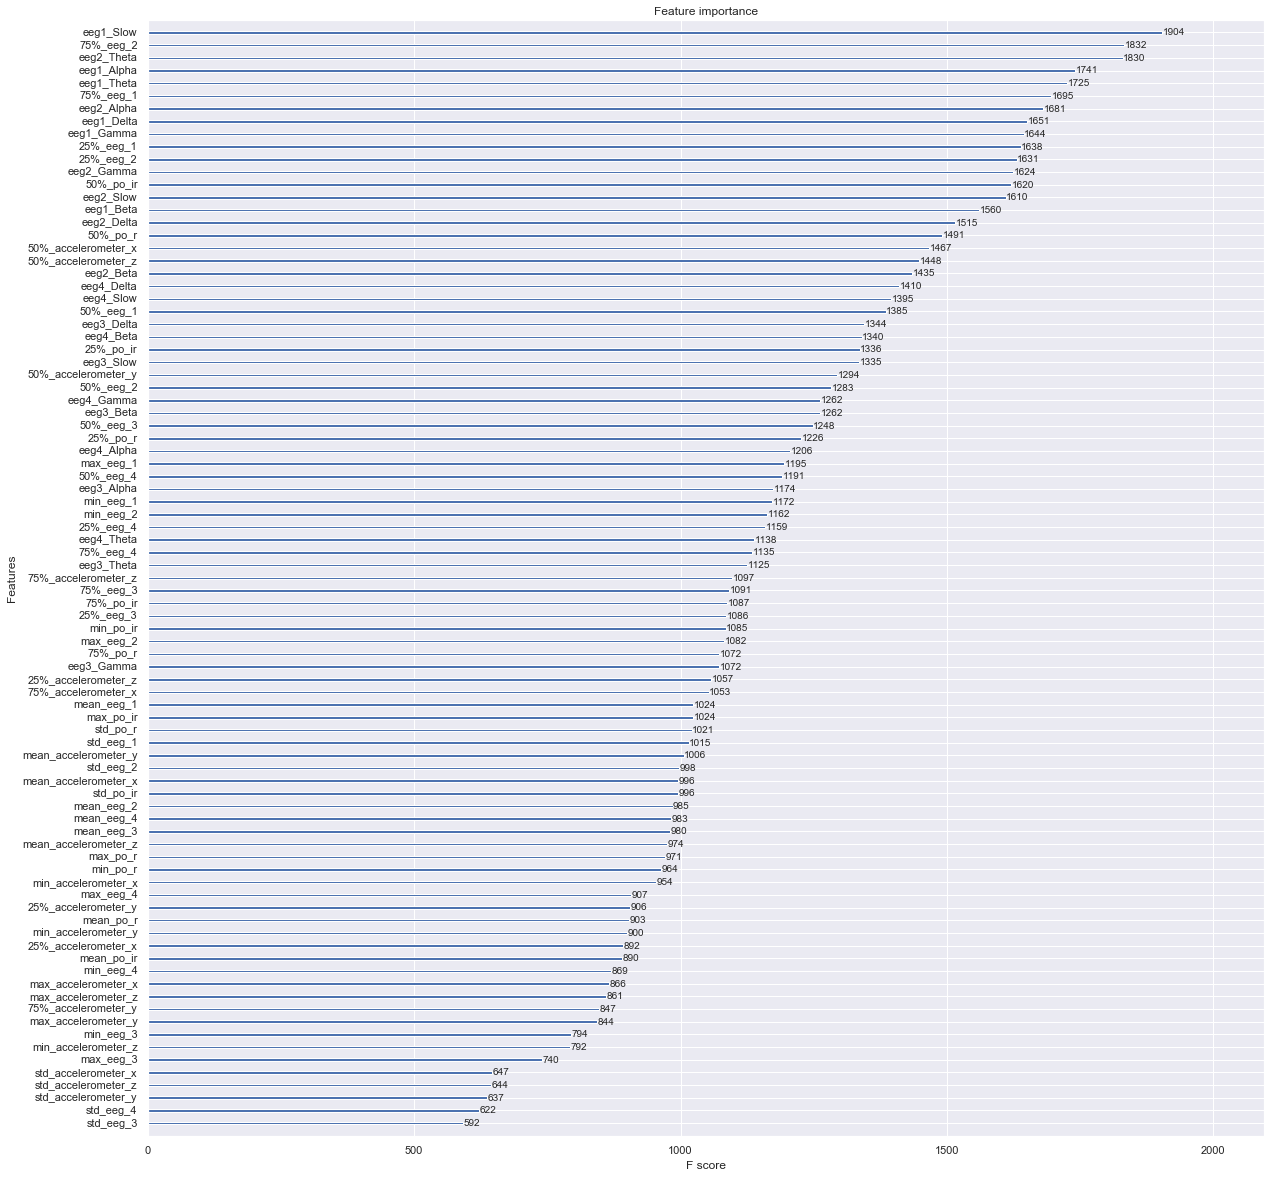

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(xbc,ax=ax,   max_num_features=110)

In [29]:
importances = xbc.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=True)


feature_importances.head(8)

,importance
std_eeg_3,0.005784
std_eeg_4,0.006077
std_accelerometer_y,0.006224
std_accelerometer_z,0.006292
std_accelerometer_x,0.006322
max_eeg_3,0.007230
min_accelerometer_z,0.007739
min_eeg_3,0.007758


In [30]:
low_imp =feature_importances.head(20).index
low_imp

Index(['std_eeg_3', 'std_eeg_4', 'std_accelerometer_y', 'std_accelerometer_z',
       'std_accelerometer_x', 'max_eeg_3', 'min_accelerometer_z', 'min_eeg_3',
       'max_accelerometer_y', '75%_accelerometer_y', 'max_accelerometer_z',
       'max_accelerometer_x', 'min_eeg_4', 'mean_po_ir', '25%_accelerometer_x',
       'min_accelerometer_y', 'mean_po_r', '25%_accelerometer_y', 'max_eeg_4',
       'min_accelerometer_x'],
      dtype='object')

In [31]:
%%time
# Multipaper on 1, Welch on other 
errors = []
Lk = []
La = []

X = trainM.iloc[:,:-1]
y = trainM.iloc[:,-1]
print(y.unique())
X_test = testM.iloc[:,:-1]
y_true = testM.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 170, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

[0 1 2 3 4]
considering only one epoch
log loss =  0.7242518019404308
kappa =  0.6296214605452046
accuracy =  0.7275838466803559
Wall time: 1min 36s


# Spindle 

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'Amplitude [a.u.]')

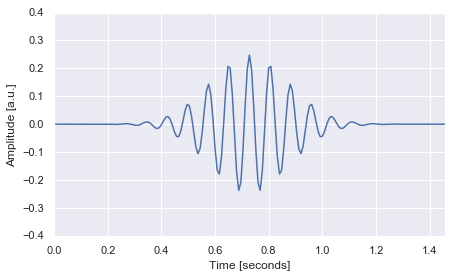

In [34]:
# Parameters
cf = 13     # Central spindles frequency in Hz
nc = 12     # Number of oscillations in the spindles
sf = 125

# Compute the wavelet
wlt = morlet(sf, [cf], n_cycles=nc)[0]

 # Plot
t = np.arange(wlt.size) / sf
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(t, wlt)
plt.ylim(-0.4, 0.4)
plt.xlim(t[0], t[-1])
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude [a.u.]')

In [179]:
N0_index =dfW[dfW.Y == 0].index
N1_index =dfW[dfW.Y == 1].index
N2_index =dfW[dfW.Y == 2].index
N3_index =dfW[dfW.Y == 3].index
N4_index =dfW[dfW.Y == 4].index

N1_index

Int64Index([   24,    25,    26,    28,    29,   125,   279,   281,   282,
              284,
            ...
            43283, 43284, 43285, 43286, 43350, 43351, 43352, 43353, 43789,
            43790],
           dtype='int64', length=1359)

In [144]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #Nyquist frequeny is half the sampling frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
filtered1 = butter_lowpass_filter(eeg_1, 20, 50, 5)
#filter the signal with a cutoff at 2.5Hz and a 5th order Butterworth filter

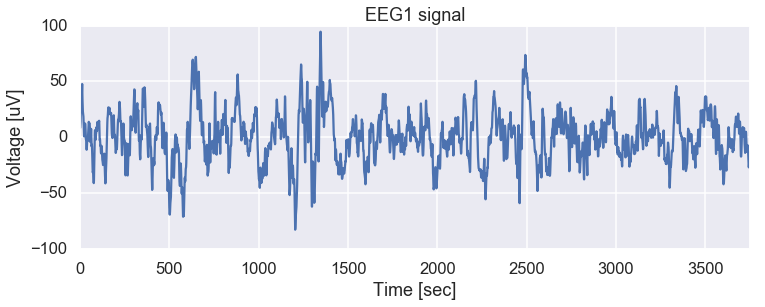

Text(0.5,1,'EEG1 signal - filtered ')

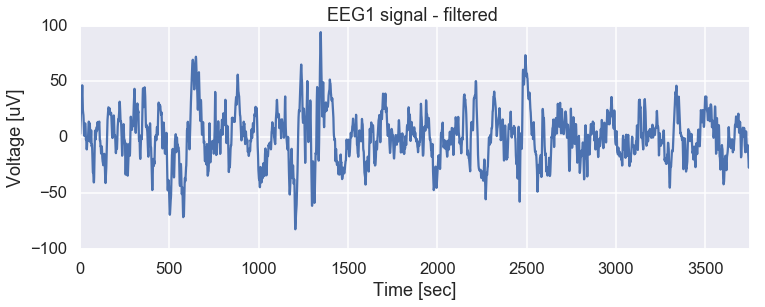

In [147]:
x = eeg_1.iloc[30, :]
sf = 125
times = np.arange(x.size) / sf

# Plot the signal
sns.set(context='talk')
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x)
plt.xlim(0, 3750)
#ax.plot(x, lw=1.75)
#ax.set_xlim(0, times[-1])
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Voltage [uV]')
ax.set_title('EEG1 signal')
plt.show()


x=filtered1[30, ] 

# Define sampling frequency and time vector
sf = 125
times = np.arange(x.size) / sf

# Plot the signal
sns.set(context='talk')
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x)
plt.xlim(0, 3750)
#ax.plot(x, lw=1.75)
#ax.set_xlim(0, times[-1])
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Voltage [uV]')
ax.set_title('EEG1 signal - filtered ')

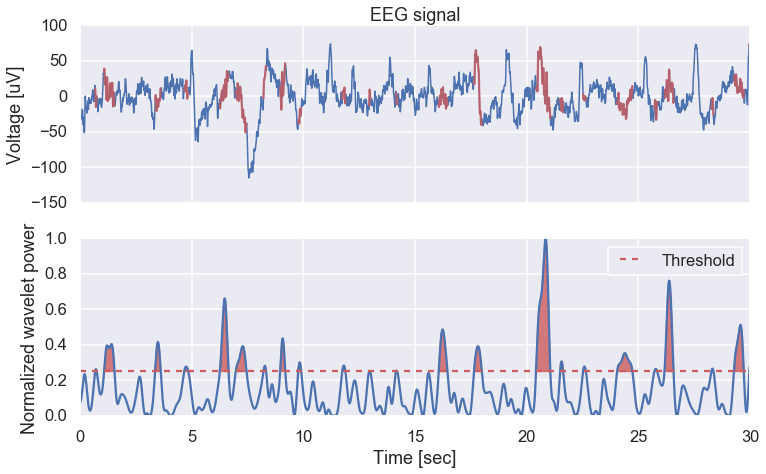

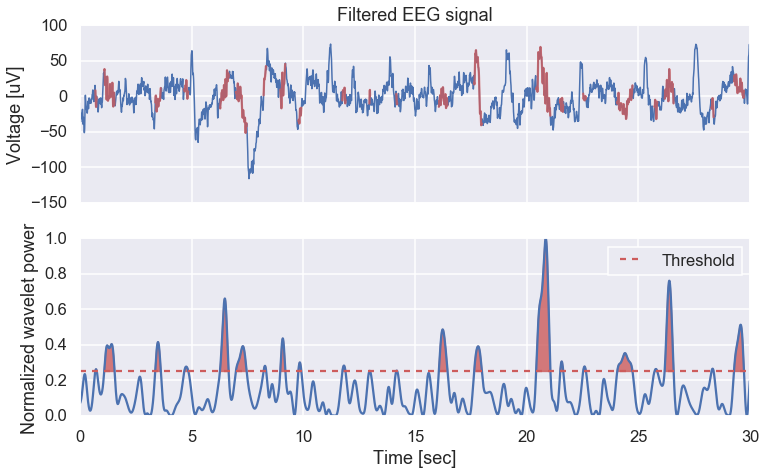

In [149]:
x = eeg_1.iloc[0, :]



# Convolve the wavelet and extract magnitude and phase
analytic = np.convolve(x, wlt, mode='same')
magnitude = np.abs(analytic)
phase = np.angle(analytic)

# Square and normalize the magnitude from 0 to 1 (using the min and max)
power = np.square(magnitude)
norm_power = (power - power.min()) / (power.max() - power.min())

# Define the threshold
thresh = 0.25

# Find supra-threshold values
supra_thresh = np.where(norm_power >= thresh)[0]

# Create vector for plotting purposes
val_spindles = np.nan * np.zeros(x.size)
val_spindles[supra_thresh] = x[supra_thresh]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax1.plot(times, x, lw=1.5)
ax1.plot(times, val_spindles, color='indianred', alpha=.8)
ax1.set_xlim(0, times[-1])
ax1.set_ylabel('Voltage [uV]')
ax1.set_title('EEG signal')

ax2.plot(times, norm_power)
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Normalized wavelet power')
ax2.axhline(thresh, ls='--', color='indianred', label='Threshold')
ax2.fill_between(times, norm_power, thresh, where = norm_power >= thresh,
                 color='indianred', alpha=.8)
plt.legend(loc='best')
plt.show()
#########

x=filtered1[0, ] 
# Convolve the wavelet and extract magnitude and phase
analytic = np.convolve(x, wlt, mode='same')
magnitude = np.abs(analytic)
phase = np.angle(analytic)

# Square and normalize the magnitude from 0 to 1 (using the min and max)
power = np.square(magnitude)
norm_power = (power - power.min()) / (power.max() - power.min())

# Define the threshold
thresh = 0.25

# Find supra-threshold values
supra_thresh = np.where(norm_power >= thresh)[0]

# Create vector for plotting purposes
val_spindles = np.nan * np.zeros(x.size)
val_spindles[supra_thresh] = x[supra_thresh]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax1.plot(times, x, lw=1.5)
ax1.plot(times, val_spindles, color='indianred', alpha=.8)
ax1.set_xlim(0, times[-1])
ax1.set_ylabel('Voltage [uV]')
ax1.set_title('Filtered EEG signal')

ax2.plot(times, norm_power)
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Normalized wavelet power')
ax2.axhline(thresh, ls='--', color='indianred', label='Threshold')
ax2.fill_between(times, norm_power, thresh, where = norm_power >= thresh,
                 color='indianred', alpha=.8)
plt.legend(loc='best')
plt.show()

In [129]:
%%time
## spindle should me more than 0.400 500 ms long
sp = np.split(supra_thresh, np.where(np.diff(supra_thresh) != 1)[0] + 1)
idx_start_end = np.array([[k[0], k[-1]] for k in sp])

# Extract the duration (in ms) of each spindles
sp_dur = (np.diff(idx_start_end, axis=1) / sf * 1000).flatten()

# Extract the peak-to-peak amplitude and frequency
sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))

for i in range(len(sp)):
    # Important: detrend the signal to avoid wrong peak-to-peak amplitude
    sp_amp[i] = np.ptp(detrend(x[sp[i]]))

    # Median of the instantaneous frequency of the spindles, where:
    # inst_freq = sf / 2pi * 1st-derivative of the phase of the analytic signal
    sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

# Create a dictionnary
sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
             'Amplitude (uV)': sp_amp}
print(sp_params)

{'Duration (ms)': array([ 64., 464., 240., 176., 384., 480., 112., 224., 128., 128.,  40.,
        48., 384., 344., 632., 128., 120., 672., 120., 400.,  80., 440.,
        16.]), 'Frequency (Hz)': array([12.29660565, 13.45912361, 12.60760439, 12.65595625, 13.12081573,
       12.42330666, 13.43621385, 13.26744911, 12.94275548, 13.11702242,
       13.15103626, 12.96188724, 12.51434843, 13.13613284, 13.28425567,
       13.26954094, 12.91130168, 12.98844577, 12.86240656, 13.03950404,
       13.24726766, 12.51956826, 13.35548572]), 'Amplitude (uV)': array([20.87084579, 38.39567566, 26.46552658, 23.33261871, 32.71508026,
       35.37091827, 17.17867661, 45.73821259, 16.27183533, 21.27529335,
       19.43406868, 10.164608  , 30.27006531, 80.97953796, 77.93978882,
       19.51659775,  7.58814812, 43.5798378 , 26.78091812, 48.71448517,
       22.68720245, 25.65657043,  1.3143158 ])}
Wall time: 29.1 ms


In [67]:
def spindles_detect(x, sf, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'}):
    """Simple spindles detector based on Morlet wavelet.

    Parameters
    ----------
    x : 1D-array
        EEG signal
    sf : float
        Sampling frequency
    thresh : float
        Threshold (0 - 1)
    wlt_params : dict
        Morlet wavelet parameters ::

        'nc' : number of oscillations
        'cf' : central frequency (int or 'auto')

    Returns
    -------
    supra_thresh_bool : 1D-array (boolean)
        Boolean array indicating for each point if it is a spindles or not.
    sp_params : dict
        Spindles parameters dictionnary.
    """
    from scipy.signal import detrend
    from mne.time_frequency import morlet, psd_array_multitaper

    if wlt_params['cf'] == 'auto':
        # Compute the power spectrum and find the peak 11-16 Hz frequency.
        psd, freqs = psd_array_multitaper(x, sf, fmin=11, fmax=16, verbose=0)
        wlt_params['cf'] = freqs[np.argmax(psd)]
        print('Central frequency: %.2f Hz' % wlt_params['cf'])

    # Compute the wavelet and convolve with data
    wlt = morlet(sf, [wlt_params['cf']], n_cycles=wlt_params['nc'])[0]
    analytic = np.convolve(x, wlt, mode='same')
    phase = np.angle(analytic)

    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(np.abs(analytic))
    norm_power = (power - power.min()) / (power.max() - power.min())

    # Find supra-threshold values and indices
    supra_thresh_bool = norm_power >= thresh
    supra_thresh_idx = np.where(norm_power >= thresh)[0]

    # Extract duration, frequency and amplitude of spindles
    sp = np.split(supra_thresh_idx, np.where(np.diff(supra_thresh_idx) != 1)[0] + 1)
    idx_start_end = np.array([[k[0], k[-1]] for k in sp])
    sp_dur = (np.diff(idx_start_end, axis=1) / sf).flatten() * 1000
    sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))
    for i in range(len(sp)):
        sp_amp[i] = np.ptp(detrend(x[sp[i]]))
        sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

    sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
                 'Amplitude (uV)': sp_amp}

    return supra_thresh_bool, sp_params

In [79]:
sf = 125
x = eeg_1.iloc[35, :]
spindles_detect(x, sf, thresh=0.25)

(array([False, False, False, ..., False, False, False]),
 {'Duration (ms)': array([504., 392.]),
  'Frequency (Hz)': array([10.78547456, 11.25919785]),
  'Amplitude (uV)': array([188.16018677,  81.63295746])})

In [83]:

sf = 125
x = eeg_1.iloc[35, :]
thresh, sp_params = spindles_detect(x, sf, thresh=0.25)

In [157]:
#np.ptp(detrend(x))
ptp1 = np.ptp(detrend(eeg_1, axis=1), axis =1)

In [160]:
print(ptp1)
print(len(ptp1))
print(np.mean(ptp1))
print(np.std(ptp1))

[188.19322 135.51227  99.05359 ... 735.2204  738.78955 561.35345]
43830
8130.41
170594.34


In [170]:
#In humans, spindles are classically defined as waxing-and-waning 10-16Hz oscillations lasting 0.5-2s
def spindles_detect_custom(x, sf, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'}):
    """Simple spindles detector based on Morlet wavelet.

    Parameters
    ----------
    x : 1D-array
        EEG signal
    sf : float
        Sampling frequency
    thresh : float
        Threshold (0 - 1)
    wlt_params : dict
        Morlet wavelet parameters ::

        'nc' : number of oscillations
        'cf' : central frequency (int or 'auto')

    Returns
    -------
    supra_thresh_bool : 1D-array (boolean)
        Boolean array indicating for each point if it is a spindles or not.
    sp_params : dict
        Spindles parameters dictionnary.
    """
    from scipy.signal import detrend
    from mne.time_frequency import morlet, psd_array_multitaper, psd_array_welch

    if wlt_params['cf'] == 'auto':
        # Compute the power spectrum and find the peak 11-16 Hz frequency.
        psd, freqs = psd_array_multitaper(x, sf, fmin=11, fmax=16, verbose=0, n_jobs=-1)
        #psd, freqs = psd_array_welch(x, sf, fmin=11, fmax=16, verbose=0, n_per_seg= 2*sf)
        wlt_params['cf'] = freqs[np.argmax(psd)]
        print('Central frequency: %.2f Hz' % wlt_params['cf'])

    # Compute the wavelet and convolve with data
    wlt = morlet(sf, [wlt_params['cf']], n_cycles=wlt_params['nc'])[0]
    analytic = np.convolve(x, wlt, mode='same')
    phase = np.angle(analytic)

    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(np.abs(analytic))
    norm_power = (power - power.min()) / (power.max() - power.min())

    # Find supra-threshold values and indices
    supra_thresh_bool = norm_power >= thresh
    supra_thresh_idx = np.where(norm_power >= thresh)[0]

    # Extract duration, frequency and amplitude of spindles
    sp = np.split(supra_thresh_idx, np.where(np.diff(supra_thresh_idx) != 1)[0] + 1)
    idx_start_end = np.array([[k[0], k[-1]] for k in sp])
    sp_dur = (np.diff(idx_start_end, axis=1) / sf).flatten() * 1000
    sp_amp = np.zeros(len(sp))
    sp_freq =  np.zeros(len(sp))
  
    for i in range(len(sp)):
        sp_amp[i] = np.ptp(detrend(x[sp[i]]))
        sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

    spindle_nb =0
    for i in range(len(sp)):
        if (sp_freq[i]>11 and sp_freq[i]<15 and sp_dur[i]>500 and sp_dur[i]<2000 and #):
            sp_amp[i]<50 and sp_amp[i]>5):
            spindle_nb +=1
        
    #sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq, 'Amplitude (uV)': sp_amp}
    #print(sp_params)
    return spindle_nb #sp_params

In [164]:
sf = 125
x = eeg_1.iloc[0, :]
spindles_detect_custom(x, sf, thresh=0.25)

Central frequency: 12.60 Hz
{'Duration (ms)': array([232., 288., 112., 208., 120., 312., 360., 464., 544., 176., 184.,
       168.,  88., 560., 424., 712.,  88., 184., 744., 280., 368., 472.,
         0.]), 'Frequency (Hz)': array([12.05423393, 11.99841117, 13.25085458, 12.83675298, 12.39961077,
       12.32419837, 12.51397042, 12.8987796 , 12.3393325 , 12.83475841,
       12.61067087, 12.82396257, 12.6713211 , 12.28041415, 12.89401517,
       12.8575966 , 12.88370204, 12.54621371, 12.90279463, 12.67512569,
       12.74939384, 12.33911119,         nan]), 'Amplitude (uV)': array([48.54418182, 28.35696411, 36.59294891, 30.00244331, 16.13904381,
       40.52078247, 27.78999519, 33.02142334, 41.17919159, 44.97225189,
       16.33593941, 20.36488342, 13.89216423, 30.15297127, 80.21337891,
       80.84213257, 18.05498314, 32.1306839 , 42.52835846, 30.83953667,
       46.36691666, 26.31788063,  0.        ])}


C:\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0

In [166]:
%%timeit
spindles_detect_custom(x, sf, thresh=0.25)

C:\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Central frequency: 12.60 Hz
24.8 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
tmp =np.array([504., 392.])

In [182]:
eval("N0_index")

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            43344, 43345, 43346, 43347, 43348, 43349, 43771, 43772, 43788,
            43802],
           dtype='int64', length=4939)

In [183]:
%%time
for idx in ["N0_index", "N1_index", "N2_index", "N3_index", "N4_index"]:
    spindle_count = 0
    for i in eval(idx):
        x = eeg_1.iloc[i, :]
        spindle_count +=spindles_detect_custom(x, sf, thresh=0.25)
    print(idx, np.round(100 * spindle_count/len(eval(idx)), 1), " %")

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N0_index 7.9  %
N1_index 28.7  %
N2_index 24.3  %
N3_index 7.8  %
N4_index 56.2  %
Wall time: 6min 54s


In [185]:
%%time
for idx in ["N0_index", "N1_index", "N2_index", "N3_index", "N4_index"]:
    spindle_count = 0
    for i in eval(idx):
        x = eeg_2.iloc[i, :]
        spindle_count +=spindles_detect_custom(x, sf, thresh=0.25)
    print(idx, np.round(100 * spindle_count/len(eval(idx)), 1), " %")

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N0_index 7.4  %
N1_index 25.0  %
N2_index 22.9  %
N3_index 7.3  %
N4_index 49.7  %
Wall time: 7min 24s


In [203]:
%%time
eeg_1 = pd.DataFrame(h5['eeg_1'][:])
eeg_2 = pd.DataFrame(h5['eeg_2'][:])
eeg_3 = pd.DataFrame(h5['eeg_3'][:])
eeg_4 = pd.DataFrame(h5['eeg_4'][:])

naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')
eeg = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
pulse = pulse.drop(columns = ['max_r', 'min_r', 'max_ir', 'min_ir']) #remove features that are double
#pulse = pulse.drop(columns =['BPMlessthan30_ir', 'BPMlessthan30_r']) # remove features with no importance 
eeg.drop(columns=["eeg1_Above100Hz0", "eeg2_Above100Hz0", "eeg3_Above100Hz0", "eeg4_Above100Hz0"], inplace=True)
#pulseAmp = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_ampTrain.csv')
#pulseAmp = pulseAmp.iloc[:, 1:]

eeg["#Spindle1"]= np.zeros(eeg.shape[0])
eeg["#Spindle2"]= np.zeros(eeg.shape[0])
eeg["#Spindle3"]= np.zeros(eeg.shape[0])
eeg["#Spindle4"]= np.zeros(eeg.shape[0])

for i in eeg_1.index:
    eeg.loc[i, "#Spindle1"] = spindles_detect_custom(eeg_1.iloc[i, :], sf, thresh=0.25)
    eeg.loc[i, "#Spindle2"] = spindles_detect_custom(eeg_2.iloc[i, :], sf, thresh=0.25)
    eeg.loc[i, "#Spindle3"] = spindles_detect_custom(eeg_3.iloc[i, :], sf, thresh=0.25)
    eeg.loc[i, "#Spindle4"] = spindles_detect_custom(eeg_4.iloc[i, :], sf, thresh=0.25)
    if (i %1000 ==0):
        print(round(100*i/eeg_1.shape[0], 1), "completed")

0.0 completed


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2.3 completed
4.6 completed
6.8 completed
9.1 completed
11.4 completed
13.7 completed
16.0 completed
18.3 completed
20.5 completed
22.8 completed
25.1 completed
27.4 completed
29.7 completed
31.9 completed
34.2 completed
36.5 completed
38.8 completed
41.1 completed
43.3 completed
45.6 completed
47.9 completed
50.2 completed
52.5 completed
54.8 completed
57.0 completed
59.3 completed
61.6 completed
63.9 completed
66.2 completed
68.4 completed
70.7 completed
73.0 completed
75.3 completed
77.6 completed
79.9 completed
82.1 completed
84.4 completed
86.7 completed
89.0 completed
91.3 completed
93.5 completed
95.8 completed
98.1 completed
Wall time: 28min 47s


In [204]:
eeg.columns

Index(['eeg1_Delta0', 'eeg1_Theta0', 'eeg1_Alpha0', 'eeg1_Beta0',
       'eeg1_Gamma0', 'eeg2_Delta0', 'eeg2_Theta0', 'eeg2_Alpha0',
       'eeg2_Beta0', 'eeg2_Gamma0', 'eeg3_Delta0', 'eeg3_Theta0',
       'eeg3_Alpha0', 'eeg3_Beta0', 'eeg3_Gamma0', 'eeg4_Delta0',
       'eeg4_Theta0', 'eeg4_Alpha0', 'eeg4_Beta0', 'eeg4_Gamma0', '#Spindle1',
       '#Spindle2', '#Spindle3', '#Spindle4'],
      dtype='object')

In [205]:
eeg.head()

,eeg1_Delta0,eeg1_Theta0,eeg1_Alpha0,eeg1_Beta0,eeg1_Gamma0,eeg2_Delta0,eeg2_Theta0,eeg2_Alpha0,eeg2_Beta0,eeg2_Gamma0,...,eeg3_Gamma0,eeg4_Delta0,eeg4_Theta0,eeg4_Alpha0,eeg4_Beta0,eeg4_Gamma0,#Spindle1,#Spindle2,#Spindle3,#Spindle4
0,15067.384836,791.799053,526.234402,238.067846,8.873436,1.553901e+04,1.211022e+03,592.088885,258.187675,9.665757,...,2.202641,1302.905092,127.154376,116.598434,52.068872,5.611631,2.0,0.0,0.0,0.0
1,6194.997941,870.974146,724.313661,222.860622,12.592876,1.498578e+04,1.431564e+03,912.804498,225.851998,10.602561,...,2.492318,1579.926843,234.639812,180.622176,53.639204,5.471912,2.0,1.0,1.0,1.0
2,4574.792936,498.015318,548.223114,169.697156,11.446063,1.347092e+04,1.351802e+03,653.645947,206.578801,9.582789,...,2.734685,2080.340276,245.280552,165.941398,71.199429,5.265627,0.0,0.0,0.0,0.0
3,317175.991019,14574.874852,19000.159158,892.029313,18.739333,3.123085e+07,6.766067e+05,165130.691286,14969.208303,384.833126,...,2.280768,37190.483732,1953.718173,763.837164,107.348233,4.440513,0.0,0.0,0.0,0.0
4,58746.615386,7275.947515,15771.361858,664.287392,16.583832,6.828195e+06,1.185932e+06,203716.821691,23404.834724,326.066719,...,2.564934,29622.811770,2236.368108,982.018666,130.172671,6.372862,0.0,0.0,0.0,0.0


In [ ]:
Reference one 1 epoch (previous)
- log loss =  0.7206771579062425
- kappa =  0.6518430793293312
- accuracy =  0.74366872005475

(new) eeg + naif
- log loss =  0.6990058512874828
- kappa =  0.6549201342792562

(new) eeg + pulse + naif
- log loss =  0.7045746186176681
- kappa =  0.6579936897373033

(new) eeg + pulse + naif, dropping ['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir']
- log loss =  0.6960332634858694
- kappa =  0.6587795975356928

??:
-log loss =  0.7001175747835894
- kappa =  0.6586589724834191

dropping in addition ['eeg4_energy', 'eeg3_energy', 'MAD_r', 'max_eeg_3']
- log loss =  0.7020145307848867
- kappa =  0.6479186069682229

(new) eeg + all
- log loss =  0.695721407589258
- kappa =  0.6574798196459137

acc and pulse bring very little. it is in fact less good with Acc than without

In [207]:
#df = pd.concat([eeg, acc, pulse, naif], axis=1)
#df = pd.concat([eeg,  pulse, naif], axis=1)
#df.drop(columns=['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir'], inplace=True) 
#df.drop(columns=['eeg4_energy', 'eeg3_energy', 'MAD_r', 'max_eeg_3'],inplace= True)
# drop less important features 
#print("OK")

#df = pd.concat([eeg, naif], axis=1)


df1 =eeg.iloc[:, :-5].copy()
df1["Y"] = naif.iloc[:,-1]
df2 = eeg.copy()
df2["Y"] = naif.iloc[:,-1]
df3 = pd.concat([eeg,  naif], axis=1)
df4 = pd.concat([eeg,  pulse, naif], axis=1)
df5 = pd.concat([eeg,  pulse, naif], axis=1)
df5.drop(columns=['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir'], inplace=True) 
df5.drop(columns=[ 'MAD_r', 'max_eeg_3'],inplace= True)

print(df2["Y"].unique())
df1.columns


[0 1 2 3 4]


Index(['eeg1_Delta0', 'eeg1_Theta0', 'eeg1_Alpha0', 'eeg1_Beta0',
       'eeg1_Gamma0', 'eeg2_Delta0', 'eeg2_Theta0', 'eeg2_Alpha0',
       'eeg2_Beta0', 'eeg2_Gamma0', 'eeg3_Delta0', 'eeg3_Theta0',
       'eeg3_Alpha0', 'eeg3_Beta0', 'eeg3_Gamma0', 'eeg4_Delta0',
       'eeg4_Theta0', 'eeg4_Alpha0', 'eeg4_Beta0', 'Y'],
      dtype='object')

In [208]:
errors = []
Lk = []
La = []

for ndf in ["df1", "df2", "df3", "df4", "df5"]:
    df = eval(ndf)
    train = df.iloc[0:int(df.shape[0]*0.8), :]
    test = df.iloc[int(df.shape[0]*0.8):, :]
    X = train.iloc[:,:-1]
    y = train.iloc[:,-1]
    print(y.unique())
    X_test = test.iloc[:,:-1]
    y_true = test.iloc[:,-1]
    xbc = xgb.XGBClassifier(n_estimators = 170, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for ", ndf)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[0 1 2 3 4]
for  df1
log loss =  0.799726740393983
kappa =  0.585626096357163
accuracy =  0.6948437143509012
[0 1 2 3 4]
for  df2
log loss =  0.8031890603312546
kappa =  0.5834210509613444
accuracy =  0.6933607118412046
[0 1 2 3 4]
for  df3
log loss =  0.7374470708889758
kappa =  0.6374393468861985
accuracy =  0.7332877024868811
[0 1 2 3 4]
for  df4
log loss =  0.726403495431837
kappa =  0.6514257921700476
accuracy =  0.7435546429386265
[0 1 2 3 4]
for  df5
log loss =  0.72292806721725
kappa =  0.6465746802889654
accuracy =  0.7395619438740588


In [187]:
%%time
errors = []
Lk = []
La = []
dfi =df.copy()

for col in low_imp:
    print(col)
    dfi.drop(columns=[col], inplace=True) 

    train = dfi.iloc[0:int(df.shape[0]*0.8), :]
    test = dfi.iloc[int(df.shape[0]*0.8):, :]

    X = train.iloc[:,:-1]
    y = train.iloc[:,-1]
    print(y.unique())
    X_test = test.iloc[:,:-1]
    y_true = test.iloc[:,-1]
    xbc = xgb.XGBClassifier(n_estimators = 170, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("dropping", col)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

eeg4_energy
[0 1 2 3 4]
dropping eeg4_energy
log loss =  0.7026961123527679
kappa =  0.6542579249906033
accuracy =  0.745265799680584
eeg3_energy
[0 1 2 3 4]
dropping eeg3_energy
log loss =  0.7051132944178835
kappa =  0.6521785923031731
accuracy =  0.7437827971708875
MAD_r
[0 1 2 3 4]
dropping MAD_r
log loss =  0.6904437851494868
kappa =  0.6544578540602065
accuracy =  0.7454939539128451
max_eeg_3
[0 1 2 3 4]
dropping max_eeg_3
log loss =  0.7020145307848867
kappa =  0.6479186069682229
accuracy =  0.7407027150353639
std_accelerometer_x
[0 1 2 3 4]
dropping std_accelerometer_x
log loss =  0.7116851395389224
kappa =  0.6476364432582573
accuracy =  0.7405886379192334
MAD_ir
[0 1 2 3 4]
dropping MAD_ir
log loss =  0.6916280254786759
kappa =  0.6537927973499276
accuracy =  0.7451517225644536
eeg3_Slow
[0 1 2 3 4]
dropping eeg3_Slow
log loss =  0.7025945699546048
kappa =  0.6487373835260145
accuracy =  0.7413871777321469
min_eeg_3
[0 1 2 3 4]
dropping min_eeg_3
log loss =  0.693505258969605

without extra drop reference
- log loss =  0.6960332634858694
- kappa =  0.6587795975356928

ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

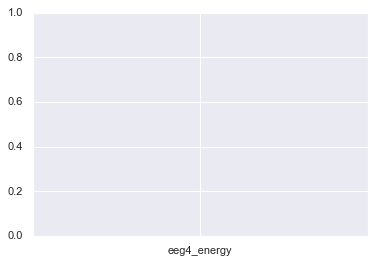

In [210]:
d=16
s = 0
r = low_imp[s:d]
plt.plot(r, errors[s:d], label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk[s:d], label = "kappa")
plt.legend(loc='lower right')
plt.show()

## with several epochs



In [218]:
def reshape_n(df, n=5):
    if ((df.shape[0] <n) or (n%2==0)):
        print("Input error!")
        return df
    r = df.shape[0]
    c = df.shape[1]
    newColumns = []
    for i in range(0, n):
        for colName in df.columns:
            newColumns.append(str(colName) + str(i+1))
    result = pd.DataFrame(columns = newColumns, data = np.zeros((r, c*n)))
    for i in range(n//2, r-n//2):
        for j in range(0, n):
            k = j-n//2
            result.iloc[i,c*j:c*(j+1)]= df.iloc[i+k, :].values
    return result

In [279]:
eeg1 = periodigram_by_eeg_bandwidth(eeg_1,  
                                     columnsName=['eeg1_Slow', 'eeg1_Delta', 'eeg1_Theta', 'eeg1_Alpha', 'eeg1_Beta', 'eeg1_Gamma', 'eeg1_energy'])
eeg2 = periodigram_by_eeg_bandwidth(eeg_2, 
                                     columnsName=['eeg2_Slow','eeg2_Delta', 'eeg2_Theta', 'eeg2_Alpha', 'eeg2_Beta', 'eeg2_Gamma', 'eeg2_energy'])
eeg3 = periodigram_by_eeg_bandwidth(eeg_3,
                                     columnsName=['eeg3_Slow','eeg3_Delta', 'eeg3_Theta', 'eeg3_Alpha', 'eeg3_Beta', 'eeg3_Gamma', 'eeg3_energy'])

eeg4 = periodigram_by_eeg_bandwidth(eeg_4,  
                                     columnsName=['eeg4_Slow','eeg4_Delta', 'eeg4_Theta', 'eeg4_Alpha', 'eeg4_Beta', 'eeg4_Gamma', 'eeg4_energy'])
eeg = pd.concat([eeg1, eeg2, eeg3, eeg4], axis=1, sort=False)


naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')
#eegO = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
pulse = pulse.drop(columns = ['max_r', 'min_r', 'max_ir', 'min_ir']) #remove features that are double
pulse = pulse.drop(columns =['BPMlessthan30_ir', 'BPMlessthan30_r']) # remove features with no importance

df = pd.concat([eeg,  pulse, naif], axis=1)
df.drop(columns=['std_eeg_1', 'std_eeg_2', 'std_eeg_3', 'std_eeg_4', 'RMSSD_r', 'IBI_r','RMSSD_ir', 'IBI_ir'], 
        inplace=True)


In [225]:
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
#xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, n_jobs=-2)
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [3, 5, 7, 9, 11, 13]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering only one epoch
log loss =  0.6933458889149816
kappa =  0.6555447855706934
accuracy =  0.7464065708418891
considering  3  epochs
log loss =  0.6048264100788329
kappa =  0.7114263613867395
accuracy =  0.7872219053051911
considering  5  epochs
log loss =  0.5851272758384408
kappa =  0.72894284562836
accuracy =  0.8004335919671383
considering  7  epochs
log loss =  0.58246949339954
kappa =  0.7250474698242327
accuracy =  0.7975579139564076
considering  9  epochs
log loss =  0.5728500588190613
kappa =  0.7183111552935763
accuracy =  0.7925131248573385
considering  11  epochs
log loss =  0.5725278441729674
kappa =  0.722929684116226
accuracy =  0.7961419929231823
considering  13  epochs
log loss =  0.5718892273058265
kappa =  0.7278922455389143
accuracy =  0.7997716894977169


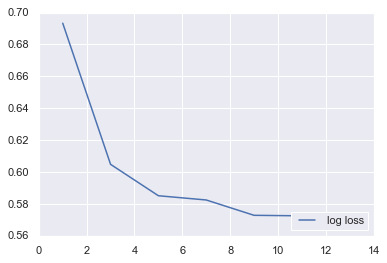

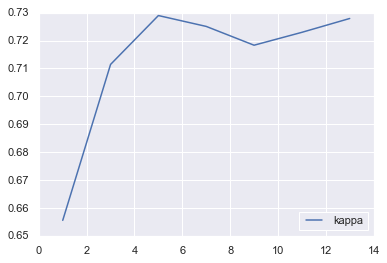

In [227]:
r =[1, 3, 5, 7, 9, 11, 13]
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [230]:
train.shape

(35064, 100)

Let's go for N=5

In [234]:
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
r = [3, 4, 5, 6, 7, 8, 9, 10]

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= i,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)b
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  3  epochs
log loss =  0.6038966893638154
kappa =  0.7104583496239589
accuracy =  0.7862604131005363
considering  4  epochs
log loss =  0.5706081996714978
kappa =  0.7218566430420215
accuracy =  0.7947050096998745
considering  5  epochs
log loss =  0.5563326520077707
kappa =  0.7269028646679889
accuracy =  0.7984708433184983
considering  6  epochs
log loss =  0.5604904516886913
kappa =  0.7269736796205903
accuracy =  0.7986990756590209
considering  7  epochs
log loss =  0.5817754121097259
kappa =  0.7151972417459245
accuracy =  0.7899121305488987
considering  8  epochs
log loss =  0.5836038357140096
kappa =  0.722768341954679
accuracy =  0.7956179390619651
considering  9  epochs
log loss =  0.5930404633072168
kappa =  0.7224002151176583
accuracy =  0.7955038228917037
considering  10  epochs
log loss =  0.6057762259161119
kappa =  0.7204446455808629
accuracy =  0.7937920803377838


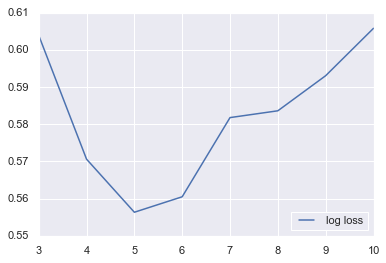

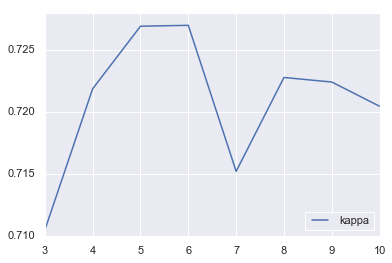

In [235]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [237]:
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
r = range(50, 210, 10)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 5,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  50  epochs
log loss =  0.6653454912138211
kappa =  0.682065432268909
accuracy =  0.7653235931971236
considering  60  epochs
log loss =  0.6412517957246058
kappa =  0.6915618728743873
accuracy =  0.7724004109119963
considering  70  epochs
log loss =  0.6256464289590816
kappa =  0.698205232739733
accuracy =  0.7773085264239242
considering  80  epochs
log loss =  0.611053795708734
kappa =  0.703869268393887
accuracy =  0.7815317886086063
considering  90  epochs
log loss =  0.5954601096354285
kappa =  0.7094145034874428
accuracy =  0.7856409085720808
considering  100  epochs
log loss =  0.5874877190090609
kappa =  0.7089624452391969
accuracy =  0.785298481908458
considering  110  epochs
log loss =  0.5800092908113524
kappa =  0.7167718081157057
accuracy =  0.7911197351900467
considering  120  epochs
log loss =  0.5711414826094263
kappa =  0.7173062073272939
accuracy =  0.7914621618536697
considering  130  epochs
log loss =  0.5672677478757628
kappa =  0.7190839205123889
accura

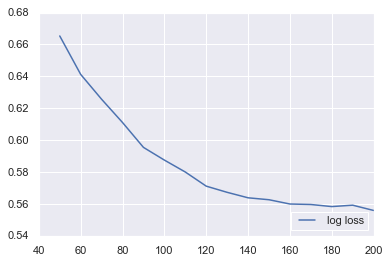

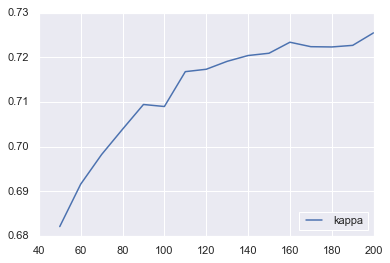

In [238]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [239]:
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
r = range(10)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = 160, random_state=42, learning_rate= 0.1, max_depth= 5,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  0  epochs
log loss =  0.58080381178463
kappa =  0.7200219670348885
accuracy =  0.7930994691899377
considering  1  epochs
log loss =  0.567815202253906
kappa =  0.7235018056160747
accuracy =  0.7958689129933072
considering  2  epochs
log loss =  0.578208774701497
kappa =  0.7175330802082719
accuracy =  0.7912531733210247
considering  3  epochs
log loss =  0.5710104094657932
kappa =  0.7210532174568623
accuracy =  0.7940226171243941
considering  4  epochs
log loss =  0.5684030163858833
kappa =  0.718641847686025
accuracy =  0.7924071082390953
considering  5  epochs
log loss =  0.5667908363297525
kappa =  0.7280216754295795
accuracy =  0.7993307177475191
considering  6  epochs
log loss =  0.5643982583026577
kappa =  0.7235778970801017
accuracy =  0.7960996999769213
considering  7  epochs
log loss =  0.5690570966054976
kappa =  0.725389791841148
accuracy =  0.7972536348949919
considering  8  epochs
log loss =  0.5684385009296378
kappa =  0.7229327018372169
accuracy =  0.795407

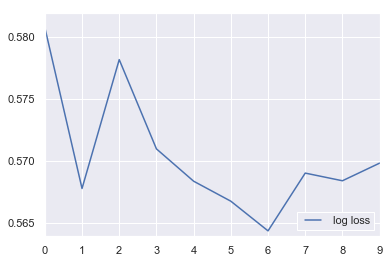

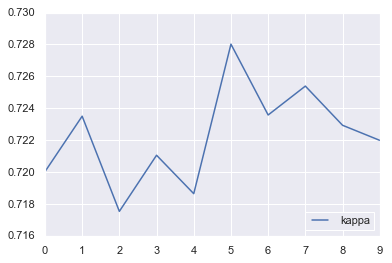

In [240]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [244]:
%%time
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

Wall time: 1min 16s


In [266]:


ck_score = make_scorer(cohen_kappa_score, greater_is_better=True)
scoring = {'neg_log_loss': 'neg_log_loss', "kappa": ck_score}

xbc = xgb.XGBClassifier(n_estimators = 2, random_state=42, learning_rate= 0.1, max_depth= 5,  subsample= 0.7, 
                        n_jobs=-2, reg_lambda=5, eval_set=[(X, y), (X_test, y_true)],verbose=True,
                        #eval_metric='logloss'
                        eval_metric=['merror']
                       )
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering ", i, " epochs")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

considering  9  epochs
log loss =  1.4223216426641911
kappa =  0.5449223853014817
accuracy =  0.6636612645514722


In [267]:
er = xbc.evals_result()
#evals_result = clf.evals_result()

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [268]:
%%time
errors = []
Lk = []
La = []

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
r = range(100, 1000, 50)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 5,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  100  epochs
log loss =  0.5916210198241618
kappa =  0.7123352789079497
accuracy =  0.7877196986989272
considering  150  epochs
log loss =  0.5673355886320749
kappa =  0.721666894546307
accuracy =  0.7947957087422963
considering  200  epochs
log loss =  0.558792569648756
kappa =  0.7287933912557496
accuracy =  0.8001597808719471
considering  250  epochs
log loss =  0.557949830908075
kappa =  0.729966358792409
accuracy =  0.8010728144259301
considering  300  epochs
log loss =  0.5605464258555982
kappa =  0.7299182223307197
accuracy =  0.8009586852316822
considering  350  epochs
log loss =  0.563630470827598
kappa =  0.7332663630813121
accuracy =  0.8034695275051358
considering  400  epochs
log loss =  0.5688336998417182
kappa =  0.7312258724086542
accuracy =  0.8019858479799132
considering  450  epochs
log loss =  0.5747186479805869
kappa =  0.7311720394059379
accuracy =  0.8018717187856653
considering  500  epochs
log loss =  0.5815515692122996
kappa =  0.7312510601541755
a

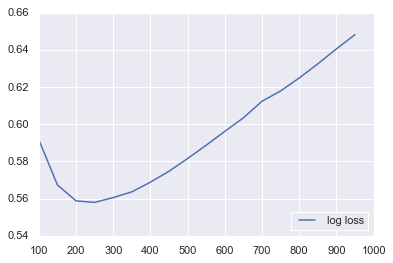

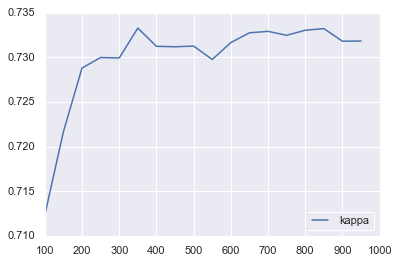

In [269]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [289]:
%%time
errors = []
Lk = []
La = []

df = make_df()
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

train5 = reshape_n(train.iloc[:,:-1], 5)
train5["Y"]= train.iloc[:,-1]
for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], 5)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
r = range(250, 280, 10)
#350 ref kappa =  0.7273361761827176
#

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 5,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  250  epochs
log loss =  0.5645705528975635
kappa =  0.7297565980249723
accuracy =  0.8008380863694564
considering  260  epochs
log loss =  0.5658880378825873
kappa =  0.7303012081686593
accuracy =  0.8011872890233965
considering  270  epochs
log loss =  0.5652297597312266
kappa =  0.7295550968174356
accuracy =  0.800605284600163
Wall time: 23min


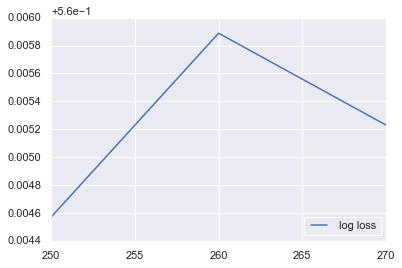

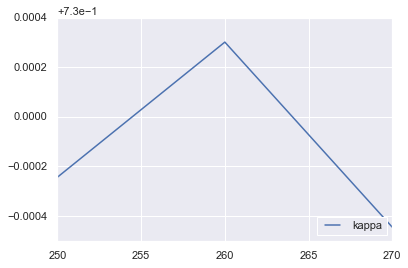

In [290]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [272]:
X.shape

(34589, 495)